# Comparaison des alternatives au covoiturage dans le RPC

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from mobfw.config import GTFS_ROUTE_TYPE_GHG, ADEME_FACTORS
from mobfw.rpc.visualisations import plot_journeys_on_map
pd.options.mode.chained_assignment = None
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex"
})
def clean_pt(pt):
    pt = pt.drop(columns=[c for c in pt.columns if c.startswith('distancept') and not pt[c].sum()]) # on supprime les moyens de transports en trop
    pt = pt[pt[[c for c in pt.columns if c.startswith('distancept')]].sum(axis=1) != 0] # on supprime là où y a que de la marche
    return pt

def calculate_pt_ghg(mobilities):
    ghg_sum = None
    for column in mobilities.columns:
        if column.startswith('distancept'):
            route_type = column[11:]
            if not route_type.isdigit():
                continue
            ghg_factor = GTFS_ROUTE_TYPE_GHG[int(route_type)]
            mobilities['ghg_' + route_type] = mobilities[column] * ghg_factor / 1000
            if ghg_sum is None:
                ghg_sum = mobilities['ghg_' + route_type]
            else:
                ghg_sum += mobilities['ghg_' + route_type]
    mobilities['ghg_pt'] = ghg_sum

def print_ghg(mobilities_pt_only):
    print("Émissions de GES en TC de ces voyageurs :", (mobilities_pt_only['ghg_pt'] * mobilities_pt_only['passenger_seats']).sum())
    print("Leurs émissions de GES en autosolisme :", (mobilities_pt_only['distance_car']  * (mobilities_pt_only['passenger_seats'])).sum() * ADEME_FACTORS["Voiture - Motorisation moyenne - 2018"] / 1000)


In [2]:
pdl = "_isere"

DATA_PATH = "../../data/mobfw/"

rpc = pd.read_pickle(DATA_PATH + "rpc" + pdl +".pkl")
ridesharing = pd.read_pickle(DATA_PATH + "ridesharing" + pdl + ".trips")
needs = pd.read_pickle(DATA_PATH + "ridesharing" + pdl + ".needs")
car_itineraries = pd.read_pickle(DATA_PATH + "ridesharing" + pdl + ".car")
pt = clean_pt(pd.read_pickle(DATA_PATH + "transit" + pdl + ".departure.pkl"))
mobilities_ridesharing = rpc.join(pd.read_pickle(DATA_PATH + "ridesharing" + pdl + ""))
itineraries_bike = pd.read_pickle(DATA_PATH + "itineraries" + pdl + ".bike")
print("Total :", rpc.shape[0], "couples passagers-conducteur")

Total : 1176 couples passagers-conducteur


In [3]:
OD_COL_NAMES = ['start_lon', 'start_lat', 'end_lon', 'end_lat']
mobilities = pd.merge(needs, car_itineraries, left_on=OD_COL_NAMES, right_index=True)

print("Nombre de voyageurs :", mobilities["passenger_seats"].sum())

Nombre de voyageurs : 2225


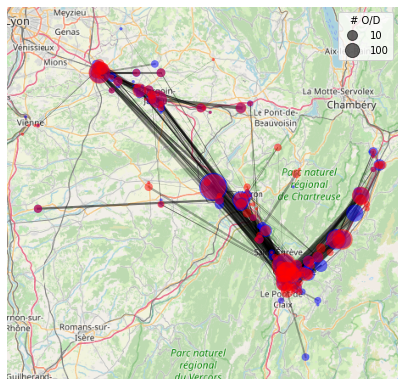

In [4]:
plt.figure(figsize=(7, 7))
plot_journeys_on_map(mobilities, scale=9, subplot_args={}, subplot_kwargs={"frameon": False})
#plt.savefig('../../publications/limits2022/figures/map' + pdl + '.pgf', bbox_inches='tight', dpi=400)
#plt.savefig('../../présentation journées des doctorants LIG 2A/map' + pdl + '.svg', bbox_inches='tight', dpi=400)

## Émissions en autosolisme

In [5]:
print("Comme calculé par le RPC (kgCO2)", (rpc['distance'] * (1 + rpc['passenger_seats'])).sum() * ADEME_FACTORS["Voiture - Motorisation moyenne - 2018"] / 1000)
mobilities["ghg_car"] = mobilities['passenger_seats'] * mobilities['distance_car'] * ADEME_FACTORS["Voiture - Motorisation moyenne - 2018"] / 1000
print("Calculé par moi", mobilities["ghg_car"].sum())
autosolism_emissions = mobilities["ghg_car"].sum()

Comme calculé par le RPC (kgCO2) (1.3+/-0.8)e+04
Calculé par moi (1.2+/-0.7)e+04


## Émissions en covoiturage

In [6]:
print("Comme calculé par le RPC (kgCO2) :", rpc['distance'].sum() * ADEME_FACTORS["Voiture - Motorisation moyenne - 2018"] / 1000)
print("Calculé par moi (kgCO2) :", ridesharing['distance'].sum() * ADEME_FACTORS['Voiture - Motorisation moyenne - 2018'] / 1000)

Comme calculé par le RPC (kgCO2) : (6+/-4)e+03
Calculé par moi (kgCO2) : (5.8+/-3.5)e+03


In [7]:
ridesharing_emissions = ridesharing['distance'].sum() * ADEME_FACTORS['Voiture - Motorisation moyenne - 2018'] / 1000

## Comparaison covoiturage / voiture

In [8]:
mobilities_ridesharing = pd.merge(mobilities_ridesharing, car_itineraries, left_on=OD_COL_NAMES, right_index=True)

In [9]:
diff_ridesharing_car = mobilities_ridesharing["time_ridesharing"] - mobilities_ridesharing["time_car"]

In [10]:
print(diff_ridesharing_car.max())

print(diff_ridesharing_car.min())
print(diff_ridesharing_car.mean())

0 days 00:15:03.474000
0 days 00:00:00
0 days 00:00:15.099595238


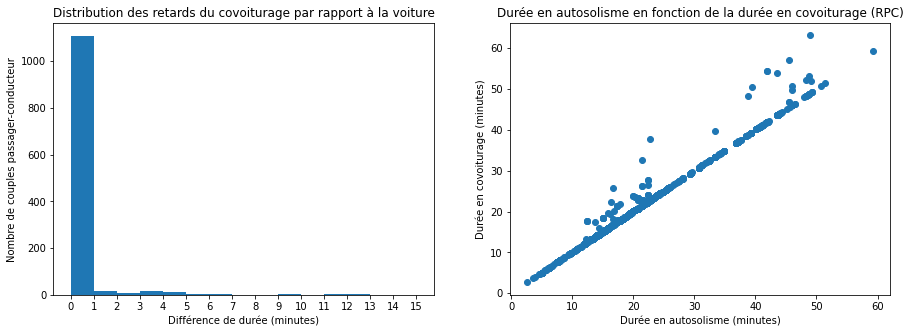

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(diff_ridesharing_car.dt.total_seconds()/60, bins=range(16))
plt.xticks(range(16));
plt.title("Distribution des retards du covoiturage par rapport à la voiture")
plt.xlabel("Différence de durée (minutes)")
plt.ylabel("Nombre de couples passager-conducteur")
plt.subplot(1,2,2)
plt.scatter(mobilities_ridesharing["time_car"].dt.total_seconds()/60, mobilities_ridesharing["time_ridesharing"].dt.total_seconds()/60)
plt.title("Durée en autosolisme en fonction de la durée en covoiturage (RPC)")
plt.xlabel("Durée en autosolisme (minutes)")
plt.ylabel("Durée en covoiturage (minutes)");

In [12]:
mobilities_ridesharing[mobilities_ridesharing["time_ridesharing"].dt.total_seconds() == 0]

Empty DataFrame
Columns: [start_datetime, end_datetime, trip_id, start_datetime_tz, start_lon, start_lat, start_insee, start_postalcode, start_department, start_town, start_country, end_datetime_tz, end_lon, end_lat, end_insee, end_postalcode, end_department, end_town, end_country, passenger_seats, operator_class, distance, duration, end_dayofweek, end_time, distance_ridesharing, time_ridesharing, distance_car, weight, time_car, transfers, snapped_waypoints]
Index: []

[0 rows x 32 columns]

In [13]:
mobilities_ridesharing[mobilities_ridesharing["trip_id"] == '83b070eb-6caa-4a56-8d4a-9db82ae63307'][['start_lon', 'start_lat', 'end_lon', 'end_lat']]

Empty DataFrame
Columns: [start_lon, start_lat, end_lon, end_lat]
Index: []

## Nombre de passagers par véhicule

In [14]:
(rpc.groupby('trip_id').sum('passenger_seats')['passenger_seats'] + 1).value_counts() / rpc.shape[0]

2    0.792517
3    0.062075
4    0.027211
5    0.000850
6    0.000850
Name: passenger_seats, dtype: float64

## Même statistiques sur "partir après une heure donnée"
Les calculs ci-dessous ne considère que ceux qui peuvent prendre les TC. Les itinéraires en TC sont calculés sachant que les voyageurs veulent partir après une certaine heure.

In [15]:
mobilities["start_dayofweek"] = mobilities["start_datetime"].dt.dayofweek
mobilities["start_time"] =  mobilities["start_datetime"].dt.time
mobilities_pt_only = pd.merge(mobilities, pt, left_on=pt.index.names, right_index=True, how="inner")

print(mobilities_pt_only["passenger_seats"].sum(), "/", mobilities["passenger_seats"].sum(), "voyageurs peuvent prendre les TC")

2215 / 2225 voyageurs peuvent prendre les TC


In [16]:
calculate_pt_ghg(mobilities_pt_only)
print_ghg(mobilities_pt_only)

mobilities_pt_only["datetime_diff"] = mobilities_pt_only["query_datetime_answered"] - mobilities_pt_only["query_datetime_expected"]
mobilities_pt_only["time_ratio"] = mobilities_pt_only["time_transit"] / mobilities_pt_only["time_car"]
mobilities_pt_only["time_diff"] = mobilities_pt_only["time_transit"] - mobilities_pt_only["time_car"]

Émissions de GES en TC de ces voyageurs : (3.7+/-2.1)e+03
Leurs émissions de GES en autosolisme : (1.2+/-0.7)e+04


<AxesSubplot:title={'center':'Différence temps en TC - temps en voiture'}, xlabel='heures', ylabel='nombre de voyageurs'>

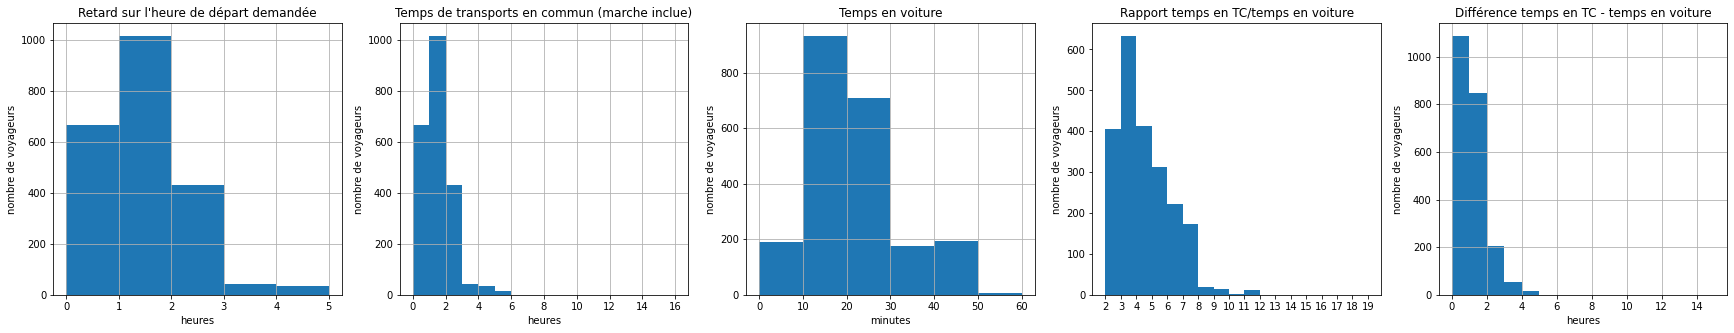

In [17]:
plt.figure(figsize=(30,5))
plt.subplot(1,5,1)
plt.title("Retard sur l'heure de départ demandée")
plt.ylabel("nombre de voyageurs")
plt.xlabel("heures")
(mobilities_pt_only["datetime_diff"].dt.total_seconds()/3600).hist(bins=range(6))
plt.subplot(1,5,2)
plt.title("Temps de transports en commun (marche inclue)")
plt.ylabel("nombre de voyageurs")
plt.xlabel("heures")
(mobilities_pt_only["time_transit"].dt.total_seconds()/3600).hist(bins=range(17))
plt.subplot(1,5,3)
plt.title("Temps en voiture")
plt.ylabel("nombre de voyageurs")
plt.xlabel("minutes")
(mobilities_pt_only["time_car"].dt.total_seconds()/60).hist(bins=range(0, 61, 10))
plt.subplot(1,5,4)
plt.title("Rapport temps en TC/temps en voiture")
plt.ylabel("nombre de voyageurs")
plt.hist((mobilities_pt_only["time_transit"].dt.total_seconds() / mobilities_pt_only["time_car"].dt.total_seconds()), bins=range(2, 20))
plt.xticks(range(2, 20));
plt.subplot(1,5,5)
plt.title("Différence temps en TC - temps en voiture")
plt.ylabel("nombre de voyageurs")
plt.xlabel("heures")
((mobilities_pt_only["time_transit"].dt.total_seconds() - mobilities_pt_only["time_car"].dt.total_seconds())/3600).hist(bins=range(16))

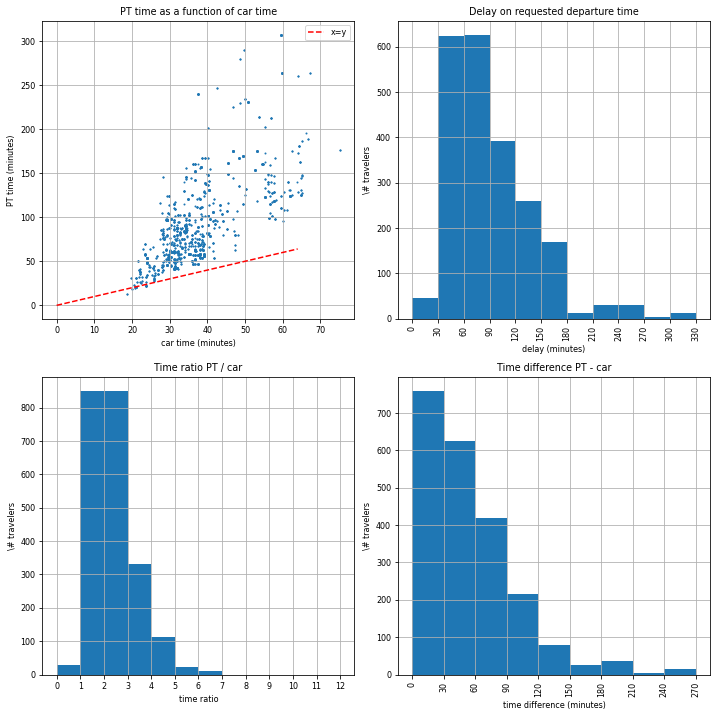

In [18]:
matplotlib.rcParams.update({'font.size': 8})
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
plt.title("Delay on requested departure time")
plt.ylabel("\# travelers")
plt.xlabel("delay (minutes)")
(mobilities_pt_only["datetime_diff"].dt.total_seconds()/60).hist(bins=range(0,6*60,30))
plt.xticks(range(0, 6*60, 30), rotation=90)

plt.subplot(2,2,3)
plt.title("Time ratio PT / car")
plt.xlabel("time ratio")
plt.ylabel("\# travelers")
plt.hist((mobilities_pt_only["time_transit"].dt.total_seconds() / (mobilities_pt_only["time_car"].dt.total_seconds() + 960)), bins=range(0, 13))
plt.xticks(range(0, 13))
plt.grid(True)

plt.subplot(2,2,4)
plt.title("Time difference PT - car")
plt.ylabel("\# travelers")
plt.xlabel("time difference (minutes)")
((mobilities_pt_only["time_transit"].dt.total_seconds() - (mobilities_pt_only["time_car"].dt.total_seconds() + 960))/60).hist(bins=range(0, 5*60, 30))
plt.xticks(range(0, 5*60, 30), rotation=90);

plt.subplot(2,2,1)
time_car = (mobilities_pt_only["time_car"].dt.total_seconds() + 960) / 60
time_transit = mobilities_pt_only["time_transit"].dt.total_seconds() / 60
c = plt.scatter(time_car, time_transit, s=1)
c.set_rasterized(True)
plt.plot(range(65), "--", color="r", label="x=y")
plt.title("PT time as a function of car time")
plt.xlabel("car time (minutes)")
plt.ylabel("PT time (minutes)")
plt.legend()
plt.grid(True)

plt.tight_layout()
#plt.savefig('../../publications/limits2022/figures/stats_rpc_car_pt.pgf', bbox_inches='tight')

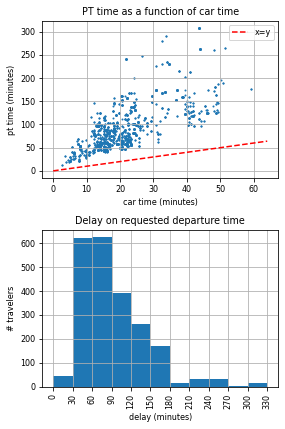

In [22]:
matplotlib.rcParams.update({'font.size': 8})
plt.figure(figsize=(4,6))
plt.subplot(2,1,2)
plt.title("Delay on requested departure time")
plt.ylabel("# travelers")
plt.xlabel("delay (minutes)")
(mobilities_pt_only["datetime_diff"].dt.total_seconds()/60).hist(bins=range(0,6*60,30))
plt.xticks(range(0, 6*60, 30), rotation=90)

plt.subplot(2,1,1)
time_car = mobilities_pt_only["time_car"].dt.total_seconds() / 60
time_transit = mobilities_pt_only["time_transit"].dt.total_seconds() / 60
c = plt.scatter(time_car, time_transit, s=1)
c.set_rasterized(True)
plt.plot(range(65), "--", color="r", label="x=y")
plt.title("PT time as a function of car time")
plt.xlabel("car time (minutes)")
plt.ylabel("pt time (minutes)")
plt.legend()
plt.grid(True)

plt.tight_layout()
#plt.savefig('../../publications/limits2022/figures/stats_rpc_car_pt' + pdl + '.pgf', bbox_inches='tight', dpi=400)
plt.savefig('../../présentation journées des doctorants LIG 2A/stats_rpc_car_pt' + pdl + '.svg', bbox_inches='tight', dpi=600)
#plt.savefig('../../redactions/analyse_rpc/figures/statistiques_rpc_voiture_tc.pgf', bbox_inches='tight')

In [22]:
mobilities_pt_only

start_lon  start_lat  end_lon  end_lat  \
4809572       5.47      45.38     5.69    45.19   
4859183       5.47      45.38     5.69    45.19   
109           5.47      45.38     5.69    45.19   
846           5.47      45.38     5.69    45.19   
4845253       5.47      45.38     5.69    45.19   
...            ...        ...      ...      ...   
9             5.10      45.64     5.70    45.17   
17            5.11      45.65     5.70    45.17   
60            5.09      45.66     5.29    45.58   
91            5.09      45.66     5.29    45.58   
67            5.10      45.65     5.44    45.56   

                                      trip_id  passenger_seats  \
4809572  aa400505-3dff-4741-94fc-7de864035c04                1   
4859183  6d8313a3-4d2d-44c6-a3d2-215fe20ee217                1   
109      aa400505-3dff-4741-94fc-7de864035c04                1   
846      6d8313a3-4d2d-44c6-a3d2-215fe20ee217                1   
4845253  7d46605d-9a16-4a9c-9827-e49046969ec2                1   
...                                       ...              ...   
9        e2ce683e-97f8-4361-b966-3c4aca97b064                1   
17       748b7d84-6089-4f65-9024-d0456bbad1b8                1   
60       33810eb6-5b41-41cf-9aa7-dfe2b21b0a3d                1   
91       83fd2b63-40a5-4cd4-94c7-5ed5ee19957b                1   
67       a6df9c2f-9e76-42ce-ada7-f3908bf91fe1                1   

             start_datetime          start_datetime_tz        end_datetime  \
4809572 2021-10-01 05:00:00  2021-10-01T05:00:00+02:00 2021-10-01 05:30:00   
4859183 2021-10-08 05:00:00  2021-10-08T05:00:00+02:00 2021-10-08 05:30:00   
109     2021-10-01 05:00:00  2021-10-01T05:00:00+02:00 2021-10-01 05:30:00   
846     2021-10-08 05:00:00  2021-10-08T05:00:00+02:00 2021-10-08 05:30:00   
4845253 2021-10-06 05:00:00  2021-10-06T05:00:00+02:00 2021-10-06 05:30:00   
...                     ...                        ...                 ...   
9       2021-10-04 18:00:00  2021-10-04T18:00:00+02:00 2021-10-04 18:50:00   
17      2021-10-11 18:00:00  2021-10-11T18:00:00+02:00 2021-10-11 18:50:00   
60      2021-10-06 17:10:00  2021-10-06T17:10:00+02:00 2021-10-06 17:30:00   
91      2021-10-11 17:00:00  2021-10-11T17:00:00+02:00 2021-10-11 17:20:00   
67      2021-10-20 17:00:00  2021-10-20T17:00:00+02:00 2021-10-20 17:30:00   

                   end_datetime_tz  ...          query_datetime_answered  \
4809572  2021-10-01T05:30:00+02:00  ... 2022-01-07 06:18:19.160000+00:00   
4859183  2021-10-08T05:30:00+02:00  ... 2022-01-07 06:18:19.160000+00:00   
109      2021-10-01T05:30:00+02:00  ... 2022-01-07 06:18:19.160000+00:00   
846      2021-10-08T05:30:00+02:00  ... 2022-01-07 06:18:19.160000+00:00   
4845253  2021-10-06T05:30:00+02:00  ... 2022-01-05 06:18:19.160000+00:00   
...                            ...  ...                              ...   
9        2021-10-04T18:50:00+02:00  ... 2022-01-03 19:19:25.603000+00:00   
17       2021-10-11T18:50:00+02:00  ... 2022-01-03 20:15:25.603000+00:00   
60       2021-10-06T17:30:00+02:00  ... 2022-01-05 17:27:45.020000+00:00   
91       2021-10-11T17:20:00+02:00  ... 2022-01-03 17:27:45.020000+00:00   
67       2021-10-20T17:30:00+02:00  ... 2022-01-05 17:34:10.021000+00:00   

        leg_count_walk  leg_count_transit                    ghg_0     ghg_2  \
4809572              2                  3                3.9+/-2.3  0.000000   
4859183              2                  3                3.9+/-2.3  0.000000   
109                  2                  3                3.9+/-2.3  0.000000   
846                  2                  3                3.9+/-2.3  0.000000   
4845253              2                  3                3.9+/-2.3  0.000000   
...                ...                ...                      ...       ...   
9                    2                  2   0.3957150249997036+/-0  0.395715   
17                   2                  2  0.48579926813968904+/-0  0.485799   
60                   2           

TC avec moins de 1 heure de retard : 669
Différence de trajet < 1 h : 1091
Les deux : 669


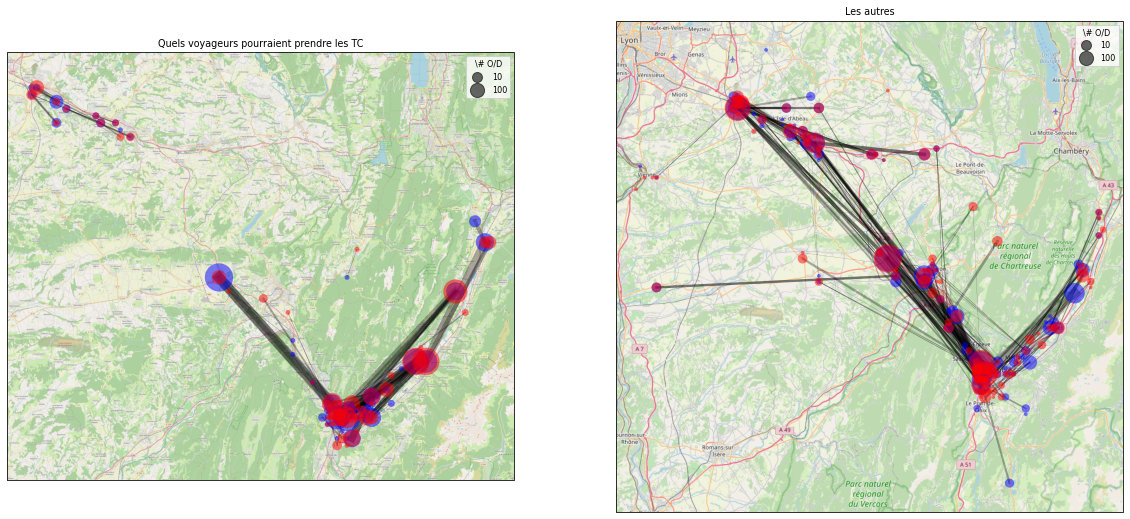

In [23]:
arrivaldifffilter = mobilities_pt_only["datetime_diff"].dt.total_seconds() < (3600)
print("TC avec moins de 1 heure de retard :", mobilities_pt_only[arrivaldifffilter]['passenger_seats'].sum())

difftimefilter = (mobilities_pt_only["time_transit"].dt.total_seconds() - mobilities_pt_only["time_car"].dt.total_seconds()) < (60 * 60)
print("Différence de trajet < 1 h :", mobilities_pt_only[difftimefilter]['passenger_seats'].sum())

print("Les deux :", mobilities_pt_only[difftimefilter & arrivaldifffilter]['passenger_seats'].sum())

plt.figure(figsize=(20, 25))
plot_journeys_on_map(mobilities_pt_only[difftimefilter & arrivaldifffilter], scale=12, subplot_args=[2,2,1])
plt.title("Quels voyageurs pourraient prendre les TC");
plot_journeys_on_map(mobilities_pt_only[~(difftimefilter & arrivaldifffilter)], scale=10, subplot_args=[2,2,2])
plt.title("Les autres");

In [24]:
mobilities_pt_only[difftimefilter & arrivaldifffilter].iloc[0]

start_lon                                                  5.89
start_lat                                                 45.26
end_lon                                                    5.76
end_lat                                                   45.18
trip_id                    bcec8c63-9c35-47fc-aaa8-3f85a4bc1b18
passenger_seats                                               1
start_datetime                              2021-10-01 07:10:00
start_datetime_tz                     2021-10-01T07:10:00+02:00
end_datetime                                2021-10-01 07:20:00
end_datetime_tz                       2021-10-01T07:20:00+02:00
start_insee                                               38140
end_insee                                                 38421
driver                                                    False
distance_car                                          17594.856
weight                                               951.050983
time_car                                

### Distance de marche

<AxesSubplot:title={'center':'Distance de marche en prenant les tc'}, xlabel='distance (m)', ylabel='nombre de voyageurs'>

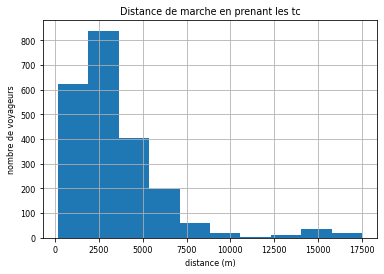

In [25]:
plt.figure()
plt.title("Distance de marche en prenant les tc")
plt.xlabel("distance (m)")
plt.ylabel("nombre de voyageurs")
mobilities_pt_only["distance_walk"].hist()

Text(0.5, 1.0, 'Nombre de trajets par nombre de différents TC pris\n(exemple : 2 lignes de bus, 1 ligne de tram = 3 TC pris)')

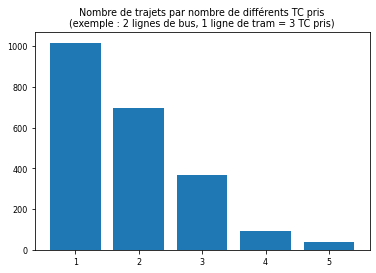

In [26]:
plt.bar(mobilities_pt_only["leg_count_transit"].value_counts().index, mobilities_pt_only["leg_count_transit"].value_counts().values)
plt.title("Nombre de trajets par nombre de différents TC pris\n(exemple : 2 lignes de bus, 1 ligne de tram = 3 TC pris)")

# Modèle de choix simple

Spécification : dans l'ordre de priorité, les émissions associées à chaque trajet le sont selon les conditions suivantes :

1) conditions mobilité douce (0 CO2/km) : durée vélo < 30 min
2) conditions TC : durée TC < 1 h
3) (conditions covoiturage : durée covoiturage < 1 h)
4) autosolisme pour tous les autres

In [27]:
mobilities = pd.merge(mobilities, pt, left_on=pt.index.names, right_index=True, how="left") # ajout des pt
calculate_pt_ghg(mobilities)
mobilities = pd.merge(mobilities, itineraries_bike, left_on=['start_lon', 'start_lat', 'end_lon', 'end_lat'], right_index=True, how="left") # ajout du vélo

In [28]:
condition_transit = mobilities["time_transit"] < pd.Timedelta(60, unit="min")
#condition_transit = mobilities["time_transit"] < 3 * mobilities["time_car"]
#condition_transit = (mobilities["time_transit"] < 2 * mobilities["time_car"]) | (mobilities["time_transit"] < pd.Timedelta(60, unit="min"))
condition_soft = mobilities["time_bike"] < pd.Timedelta(30, unit="min")

mobilities["choice"] = "car"
mobilities["ghg_choice"] = mobilities["ghg_car"]

mobilities.loc[condition_transit, ["choice"]] = "pt"
mobilities.loc[condition_transit, ["ghg_choice"]] = mobilities["ghg_pt"]

mobilities.loc[condition_soft, ["choice"]] = "soft"
mobilities.loc[condition_soft, ["ghg_choice"]] = 0

mobilities["ghg_choice_total"] = mobilities["passenger_seats"] * mobilities["ghg_choice"]

choices_stats = mobilities.groupby(["choice"]).agg({'passenger_seats': 'sum', 'ghg_choice_total': 'sum'})
choices_stats["passenger_seats_share"] = choices_stats["passenger_seats"] / mobilities["passenger_seats"].sum()

In [29]:
mobilities[mobilities["choice"] == "soft"]["time_bike"]

4810858   0 days 00:14:49.822000
530       0 days 00:14:49.822000
4811323   0 days 00:16:31.052000
4890557   0 days 00:16:31.052000
4898363   0 days 00:16:31.052000
                   ...          
41        0 days 00:12:16.857000
5023969   0 days 00:12:09.297000
42        0 days 00:12:09.297000
5027407   0 days 00:12:29.582000
610       0 days 00:12:29.582000
Name: time_bike, Length: 163, dtype: timedelta64[ns]

In [30]:
cond_emissions = choices_stats['ghg_choice_total'].sum()

In [31]:
#choices_stats

In [32]:
avoided_emissions = cond_emissions - ridesharing_emissions

In [33]:
avoided_emissions

5511.201583400873+/-2701.243877168027